In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import torch
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision import transforms

In [3]:
CLASS = [["c0", "Safe Driving"], ["c1", "Text"], ["c2", "Phone"], 
         ["c3", "Adjusting Radio"], ["c4", "Drinking"], 
         ["c5", "Reaching Behind"], ["c6", "Hair or Makeup"], 
         ["c7", "Talking to Passenger"]]
TEST_CLS = [os.path.join(os.getcwd(), "Distracted Driver Dataset", "Combined", "test", cls[0]) for cls in CLASS]
TRAIN_CLS = [os.path.join(os.getcwd(), "Distracted Driver Dataset", "Combined", "train", cls[0]) for cls in CLASS]
for cls_path in TEST_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))
for cls_path in TRAIN_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))

c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c0
346
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c1
393
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c2
364
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c3
170
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c4
143
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c5
143
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c6
146
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\

In [5]:
def make_deeplab(device):
    deeplab = deeplabv3_resnet101(weights=True).to(device)
    deeplab.eval()
    return deeplab

device = torch.device("cpu")
deeplab = make_deeplab(device)

c:\Users\wamik\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(48, 64)
[[0.         0.         0.         ... 0.32156863 0.99607843 0.99607843]
 [0.         0.         0.         ... 0.86666667 1.         1.        ]
 [0.         0.         0.         ... 1.         1.         1.        ]
 ...
 [0.         0.         0.         ... 0.09803922 0.60784314 0.38431373]
 [0.         0.         0.         ... 0.41568627 0.27843137 0.11372549]
 [0.         0.         0.         ... 0.21176471 0.03921569 0.05882353]]


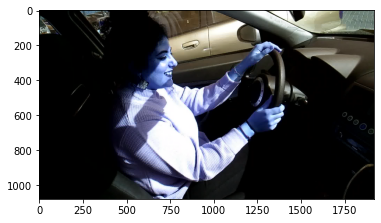

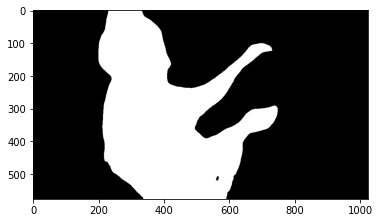

In [7]:
image = cv2.imread(os.path.join(TRAIN_CLS[4], os.listdir(TRAIN_CLS[4])[0]))
image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
image = cv2.resize(image, (64, 48), interpolation=cv2.INTER_AREA)
print(image.shape)
image = image/255
print(image)

img_orig = cv2.imread(os.path.join(TRAIN_CLS[0], os.listdir(TRAIN_CLS[0])[0]), cv2.COLOR_RGB2GRAY)
plt.imshow(img_orig)
plt.show()
k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
img = cv2.resize(img_orig, None, fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)

deeplab_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def apply_deeplab(deeplab, img, device):
    input_tensor = deeplab_preprocess(img)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = deeplab(input_batch.to(device))['out'][0]
    output_predictions = output.argmax(0).cpu().numpy()
    return (output_predictions == 15)

mask = apply_deeplab(deeplab, img, device)

plt.imshow(mask, cmap='gray')
plt.show()

In [290]:
train_paths = []
test_paths = []
for cls in range(8):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    train_paths.append(os.path.join(TRAIN_CLS[cls], train_instance))
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_paths.append(os.path.join(TEST_CLS[cls], test_instance))

In [291]:
classes = []
test_classes = []
for cls in range(8):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    classes.append(cls)
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_classes.append(cls)

In [292]:
df = pd.DataFrame({
  'filename': train_paths,
  'class': classes
})
df

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
12550,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
12551,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
12552,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
12553,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


In [293]:
df_test = pd.DataFrame({
  'filename': test_paths,
  'class': test_classes
})
df_test

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
1918,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
1919,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
1920,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
1921,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


<AxesSubplot:>

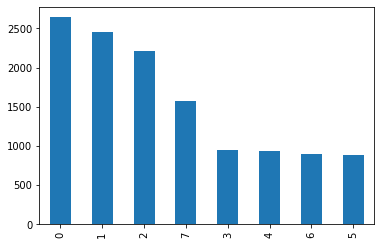

In [294]:
df['class'].value_counts().plot.bar()

<AxesSubplot:>

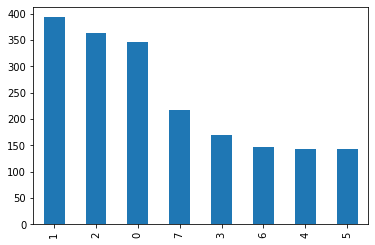

In [295]:
df_test['class'].value_counts().plot.bar()

In [296]:
df_all_data = pd.concat([df, df_test], ignore_index=True)
df_all_data

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
14473,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
14474,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
14475,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
14476,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


In [297]:
data = []
labels = []
for index, path in df.iterrows():
    image = cv2.imread(path[0])
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    image = cv2.resize(image, (64, 48), interpolation=cv2.INTER_AREA)
    image = image/255
    data.append(image)
    labels.append(path[1])

In [298]:
print(len(labels))

12555


In [299]:
data = np.asarray(data)
data = data.reshape(data.shape[0], -1)
labels = np.asarray(labels)

In [300]:
# (X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.5, stratify=labels, random_state=42)
# X_train = np.asarray(X_train)
# Y_train = np.asarray(Y_train)
# X_test = np.asarray(X_test)
# Y_test = np.asarray(Y_test)
# X_train = X_train.reshape(X_train.shape[0],-1)
# X_test = X_test.reshape(X_test.shape[0],-1)

In [301]:
# print(X_train.shape)
# print(Y_train.shape)

In [302]:
# parameters_knn = {'n_neighbors':[5, 7, 10, 15], 'weights': ['uniform', 'distance'], 'p': range(1,4), 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}

# scoring_metrics = ["accuracy", "precision_weighted", "recall_weighted", "roc_auc_ovr_weighted", "f1_weighted"]
# clf_knn = GridSearchCV(KNeighborsClassifier(), param_grid=parameters_knn, cv=5, n_jobs=-1, scoring=scoring_metrics, refit="roc_auc_ovr_weighted")

# clf_knn.fit(X=data, y=labels)

# print ("The best ROC AUC for KNN:", clf_knn.best_score_ * 100, "%, with", clf_knn.best_params_) 

In [303]:
clf_knn = KNeighborsClassifier(n_neighbors=82, weights='distance')
clf_knn.fit(data, labels)
print(clf_knn.classes_)

[0 1 2 3 4 5 6 7]


In [304]:
tdata = []
tlabels = []
for index, path in df_test.iterrows():
    image = cv2.imread(path[0])
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    image = cv2.resize(image, (64, 48), interpolation=cv2.INTER_AREA)
    image = image/255
    tdata.append(image)
    tlabels.append(path[1])

In [305]:
tdata = np.asarray(tdata)
tdata = tdata.reshape(tdata.shape[0], -1)
tlabels = np.asarray(tlabels)

In [306]:
# print(clf_knn.score(X_test, Y_test))
print(clf_knn.score(tdata, tlabels))
predictions = clf_knn.predict(tdata)

0.29901196047841916


In [307]:
tlabels_new = []
for l in tlabels:
    if l!=0:
        tlabels_new.append(1)
    else:
        tlabels_new.append(0)
predictions_new = []
for pred in predictions:
    if pred!=0:
        predictions_new.append(1)
    else:
        predictions_new.append(0)

In [308]:
print(classification_report(tlabels_new, predictions_new))

              precision    recall  f1-score   support

           0       0.33      0.34      0.34       346
           1       0.85      0.85      0.85      1577

    accuracy                           0.76      1923
   macro avg       0.59      0.59      0.59      1923
weighted avg       0.76      0.76      0.76      1923



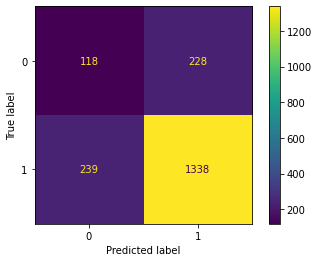

In [309]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


cm_knn = confusion_matrix(tlabels_new, predictions_new, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=[0, 1])  
disp.plot()

              precision    recall  f1-score   support

           0       0.33      0.34      0.34       346
           1       0.35      0.39      0.37       393
           2       0.22      0.30      0.25       364
           3       0.43      0.35      0.38       170
           4       0.11      0.18      0.14       143
           5       0.68      0.69      0.68       143
           6       0.00      0.00      0.00       146
           7       0.10      0.05      0.06       218

    accuracy                           0.30      1923
   macro avg       0.28      0.29      0.28      1923
weighted avg       0.28      0.30      0.29      1923



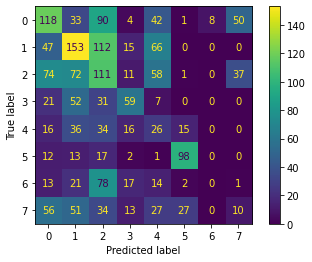

In [310]:
print(classification_report(tlabels, predictions))
cm_knn = confusion_matrix(tlabels, predictions, labels=clf_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=clf_knn.classes_)  
disp.plot()

In [311]:
data_some = []
labels_some = []
for i in range(len(labels)):
    if labels[i] in [0, 1, 3, 5]:
        data_some.append(data[i])
        labels_some.append(labels[i])
data_some = np.asarray(data_some)
labels_some = np.asarray(labels_some)

In [312]:
clf_knn_some = KNeighborsClassifier(n_neighbors=48, weights='distance')
clf_knn_some.fit(data_some, labels_some)
print(clf_knn_some.classes_)

[0 1 3 5]


In [313]:
tdata_some = []
tlabels_some = []
for i in range(len(tlabels)):
    if tlabels[i] in [0, 1, 3, 5]:
        tdata_some.append(tdata[i])
        tlabels_some.append(tlabels[i])
tdata_some = np.asarray(tdata_some)
tlabels_some = np.asarray(tlabels_some)

In [314]:
print(clf_knn_some.score(tdata_some, tlabels_some))
predictions_some = clf_knn_some.predict(tdata_some)

0.6178707224334601


              precision    recall  f1-score   support

           0       0.57      0.68      0.62       346
           1       0.56      0.59      0.57       393
           3       0.70      0.49      0.58       170
           5       0.94      0.71      0.80       143

    accuracy                           0.62      1052
   macro avg       0.69      0.62      0.64      1052
weighted avg       0.64      0.62      0.62      1052



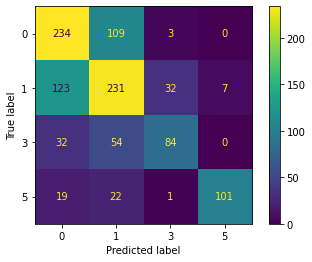

In [315]:
print(classification_report(tlabels_some, predictions_some))
cm_knn = confusion_matrix(tlabels_some, predictions_some, labels=clf_knn_some.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=clf_knn_some.classes_)  
disp.plot()

In [347]:
data_rest = []
labels_rest = []
for i in range(len(labels)):
    if labels[i] in [6, 7]:
        data_rest.append(data[i])
        labels_rest.append(labels[i])
data_rest = np.asarray(data_rest)
labels_rest = np.asarray(labels_rest)

data_last = []
labels_last = []
for i in range(len(labels)):
    if labels[i] in [0, 4]:
        data_last.append(data[i])
        labels_last.append(labels[i])
data_last = np.asarray(data_last)
labels_last = np.asarray(labels_last)

data_2 = []
labels_2 = []
for i in range(len(labels)):
    if labels[i] in [0, 2]:
        data_2.append(data[i])
        labels_2.append(labels[i])
data_2 = np.asarray(data_2)
labels_2 = np.asarray(labels_2)

In [417]:
clf_knn_rest = KNeighborsClassifier(n_neighbors=8)
clf_knn_rest.fit(data_rest, labels_rest)
print(clf_knn_rest.classes_)
clf_knn_last = KNeighborsClassifier(n_neighbors=61, weights='distance')
clf_knn_last.fit(data_last, labels_last)
print(clf_knn_last.classes_)
clf_knn_2 = KNeighborsClassifier(n_neighbors=30, weights='distance')
clf_knn_2.fit(data_2, labels_2)
print(clf_knn_2.classes_)

[6 7]
[0 4]
[0 2]


In [418]:
tdata_rest = []
tlabels_rest = []
for i in range(len(tlabels)):
    if tlabels[i] in [6, 7]:
        tdata_rest.append(tdata[i])
        tlabels_rest.append(tlabels[i])
tdata_rest = np.asarray(tdata_rest)
tlabels_rest = np.asarray(tlabels_rest)

tdata_last = []
tlabels_last = []
for i in range(len(tlabels)):
    if tlabels[i] in [0, 4]:
        tdata_last.append(tdata[i])
        tlabels_last.append(tlabels[i])
tdata_last = np.asarray(tdata_last)
tlabels_last = np.asarray(tlabels_last)

tdata_2 = []
tlabels_2 = []
for i in range(len(tlabels)):
    if tlabels[i] in [0, 2]:
        tdata_2.append(tdata[i])
        tlabels_2.append(tlabels[i])
tdata_2 = np.asarray(tdata_2)
tlabels_2 = np.asarray(tlabels_2)

In [419]:
print(clf_knn_rest.score(tdata_rest, tlabels_rest))
predictions_rest = clf_knn_rest.predict(tdata_rest)

print(clf_knn_last.score(tdata_last, tlabels_last))
predictions_last = clf_knn_last.predict(tdata_last)

print(clf_knn_2.score(tdata_2, tlabels_2))
predictions_2 = clf_knn_2.predict(tdata_2)

0.5521978021978022
0.5685071574642127
0.5084507042253521


              precision    recall  f1-score   support

           6       0.46      0.62      0.52       146
           7       0.66      0.51      0.58       218

    accuracy                           0.55       364
   macro avg       0.56      0.56      0.55       364
weighted avg       0.58      0.55      0.56       364

              precision    recall  f1-score   support

           0       0.76      0.58      0.65       346
           4       0.35      0.55      0.43       143

    accuracy                           0.57       489
   macro avg       0.55      0.56      0.54       489
weighted avg       0.64      0.57      0.59       489

              precision    recall  f1-score   support

           0       0.50      0.50      0.50       346
           2       0.52      0.51      0.52       364

    accuracy                           0.51       710
   macro avg       0.51      0.51      0.51       710
weighted avg       0.51      0.51      0.51       710



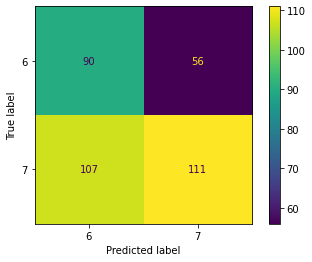

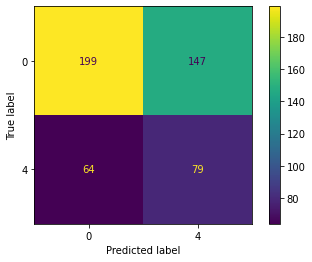

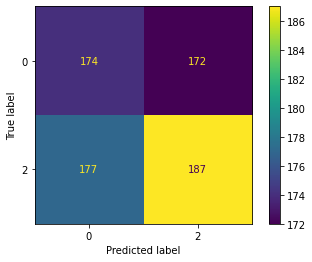

In [420]:
print(classification_report(tlabels_rest, predictions_rest))
cm_knn = confusion_matrix(tlabels_rest, predictions_rest, labels=clf_knn_rest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=clf_knn_rest.classes_)  
disp.plot()

print(classification_report(tlabels_last, predictions_last))
cm_knn = confusion_matrix(tlabels_last, predictions_last, labels=clf_knn_last.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=clf_knn_last.classes_)  
disp.plot()

print(classification_report(tlabels_2, predictions_2))
cm_knn = confusion_matrix(tlabels_2, predictions_2, labels=clf_knn_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=clf_knn_2.classes_)  
disp.plot()